# Trabalho de conclusão de curso - Data Science com ênfase em Machine Learning
## Alunos: Douglas Tadeu Sabatini & Jari Fernandes Nogueira Neto


### FIB Bauru - 06/2020

### Recortar placas das imagens.
- Processo para extração dos caracteres da placa, da imagem;
- Necessário que a imagem siga um padrão, de distância e luminosidade.

In [0]:
# Importando bibliotecas.
import numpy as np
import cv2
import imutils
import os
import matplotlib.pyplot as plt

# os.chdir('/home/jarineto/Documentos/MBA_FIB/TCC')

# TO DO:
- Aumentar o banco de fotografias;
- Fazer novo data augmentation;
- Retreinar modelos.

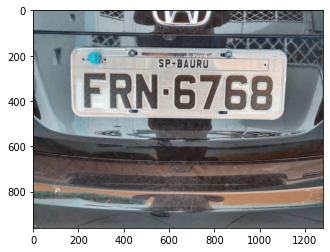

In [3]:
# Imagem que será processada.
image = cv2.imread('./Images/Recortes/Carros/Teste/OK/3.jpeg')
plt.imshow(image)
plt.show()

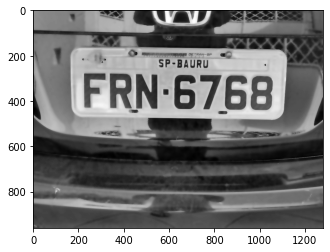

In [5]:
# Convertendo imagem para escala de cinza e aplicando blur para redução de ruídos.
gray2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
smooth2 = cv2.bilateralFilter(gray2, 15, 50, 50)
plt.imshow(smooth2, 'gray')
plt.show()

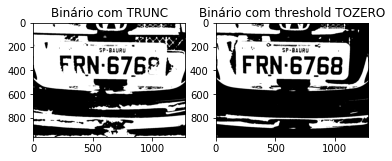

In [6]:
# Aplicando threshold e binarizando.
# São 2 possibilidades de threshold, variando a aplicação de acordo com a luminosidade da imagem.
ret3,th1 = cv2.threshold(smooth2,0,255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)
ret3,th2 = cv2.threshold(smooth2,0,255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)

_, bin1 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, bin2 = cv2.threshold(th2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(1,2,1)
plt.imshow(bin1, 'gray')
plt.title('Binário com TRUNC')

plt.subplot(1,2,2)
plt.imshow(bin2, 'gray')
plt.title('Binário com threshold TOZERO')

plt.show()

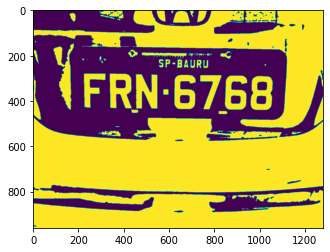

In [8]:
# Aplicando negatico à imagem e o processo de 'fechamento', uma dilatação seguida de erosão (preenchimento de falhas).
neg_img = cv2.bitwise_not(bin2)

kernel = np.ones((3,3),np.uint8)

closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)

Contornos mapeados: (215,)


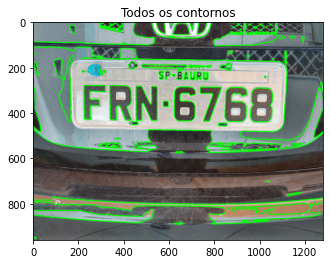

In [9]:
# Mapeia cantos.
edged = cv2.Canny(closing, 100, 200)

# Localiza contornos, baseado nos pontos mapeados.
cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('Contornos mapeados:', np.array(cnts).shape)

# Aplicando todos os contornos na imagem original e ilustrando.
img1 = image.copy()
cv2.drawContours(img1, cnts, -1, (0,255,0), 3)

plt.title("Todos os contornos")
plt.imshow(img1)
plt.show()

Contornos para tratamento:  (215,)


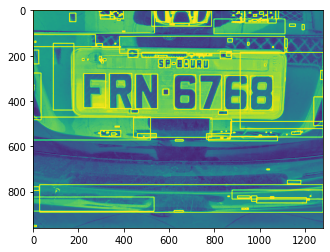

In [10]:
# Ordenando contornos, baseado em suas áreas.
cnts30 = sorted(cnts, key = cv2.contourArea, reverse = True)

# Adicionando caixas em todos os contornos.
boxes = [cv2.boundingRect(c) for c in cnts30]
print('Contornos para tratamento: ', np.array(cnts30).shape)

img = gray2

for i in range(len(boxes)):
    x, y, w, h = boxes[i]
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)

plt.imshow(img)
plt.show()

In [11]:
# Iniciando tratamento para eliminar caixas fora do padrão (possíveis não caracteres)
tempboxes = []
tempboxes_2 = []
finalboxes = []
med_h = []
med_x = []
i=0

# Filtrando por proporção de largura x altura e tamanho do pixel.
for i in range(len(boxes)):
    ref = boxes[i][3]/boxes[i][2]    
    
    if 1.3 < ref < 5.5:
        ref2 = boxes[i][3]-boxes[i][2]
        if 20 < ref2:
            tempboxes.append(boxes[i])
            med_h.append(boxes[i][3])
            

       
    i+1


j = 0
k = 0
m = np.median(med_h)

# Filtrando pela mediana de altura dos elementos.
for j in range(len(tempboxes)):
    if m*0.8 < tempboxes[j][3] < m*1.2:
        tempboxes_2.append(tempboxes[j])
        med_x.append(tempboxes[j][1])
        
p = np.median(med_x)

# Filtrando pela mediana de posição no eixo y.        
for k in range(len(tempboxes_2)):
    if p*0.95 < tempboxes_2[k][1] < p*1.05:
        finalboxes.append(tempboxes_2[k])
    
    
print('Total dentro do padrão:', np.array(tempboxes).shape)

Total dentro do padrão: (14, 4)


7


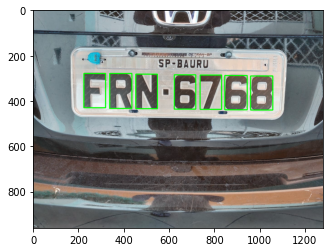

In [12]:
# Exibindo prováveis caixas dos caracteres, após filtros.
img_f = image
i=0

for i in range(len(finalboxes)):
    x, y, w, h = finalboxes[i]
    cv2.rectangle(img_f,(x,y),(x+w,y+h),(0,255,0),4)
    i+1

print(len(finalboxes))
plt.imshow(img_f)
plt.show()

In [0]:
# Lendo a imagem novamente, para recortar sem as caixas desenhadas na imagem.
gray2 = cv2.imread('./Images/Recortes/Carros/Teste/OK/3.jpeg', 0)

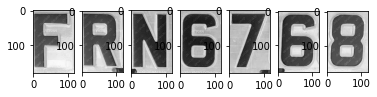

In [14]:
# Com as caixas corretas já mapeadas e definidas, ordenamos e recortando caracteres.
bd_img = []
i = 0

# Ordenando caracteres pela posição no eixo x.
finalboxes = sorted(finalboxes, key=lambda tup: tup[0])

# Recortando caracteres, com um pouco de margem (evitar cortes incompletos).
for i in range(0,7):
    x, y, w, h = finalboxes[i]   
    
    w1 = int(round((x*0.99), 0))
    w2 = int(round((w*1.22), 0))
    h1 = int(round((y*0.965), 0))
    h2 = int(round((h*1.18), 0))
    
    # Para os caracteres com proporção de base curta (I e 1), aplicamos margem maior.
    if finalboxes[i][3]/finalboxes[i][2] > 2.5: 
        w1 = int(round((x*0.96), 0))
        w2 = int(round((w*2.75), 0))
    
    new_img = gray2[h1:h1 + h2, w1:w1 + w2] # Aumento de 21% no comprimento e de 18% na altura.
    bd_img.append(new_img)

for i in range(7):
    plt.subplot(1,7,i+1),plt.imshow(bd_img[i],'gray')

# Criando funções para processar as imagens.

Tratam-se de 2 funções distintas, baseadas nas etapas feitas até aqui:
- crop_ok: Entrada imagem RGB - retorna a imagem com os prováveis caracteres detectados na imagem.
- char_proc: Entrada caminho origem + caminho destino - processa as imagens do caminho origem e salva os prováveis caracteres no caminho destino.

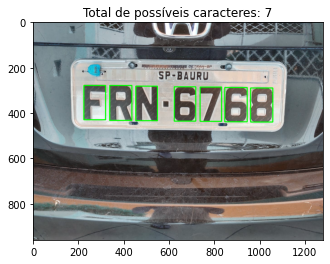

In [17]:
# Função para mapear possíveis caracteres na imagem de entrada.
image = cv2.imread('./Images/Recortes/Carros/Teste/OK/3.jpeg')
crop_ok(image)

In [0]:
# Processando em massa os arquivos que SÃO APTOS ao recorte.
## OBS: Necessário avaliar se os recortes estão corretos com a função anterior, para garantir o processo correto.
path_orig = './Images/Recortes/Carros/Teste/OK/1.1_processar' # Caminho das imagens para tratamento.
path_dest = './Images/Recortes/Carros/Teste/OK/1.2_processadas' # Caminho para gravação.

char_proc('./Images/Recortes/Carros/Teste/OK/1.1_processar', './Images/Recortes/Carros/Teste/OK/1.2_processadas')

Funções:

In [0]:
def char_proc(path_orig, path_dest):
    
    for J in range(len(os.listdir(path_orig))):
        image_to_crop = os.listdir(path_orig)[J]
        original_image = cv2.imread(path_orig+'/'+image_to_crop)

        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        smooth = cv2.bilateralFilter(gray, 15, 50, 50)
        ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)
        _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        neg_img = cv2.bitwise_not(bin_1) ## 1- trunc, 2 - tozero.
        kernel = np.ones((3,3),np.uint8)
        closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

        edged = cv2.Canny(closing, 100, 200)
        cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
        boxes = [cv2.boundingRect(c) for c in cnts_sorted]

        tempboxes = []
        tempboxes_2 = []
        finalboxes = []
        med_h = []
        med_x = []
        i=0

        for i in range(len(boxes)):
            ref = boxes[i][3]/boxes[i][2]    

            if 1.3 < ref < 5.5:
                ref2 = boxes[i][3]-boxes[i][2]

                if 20 < ref2:
                    tempboxes.append(boxes[i])
                    med_h.append(boxes[i][3])

            i+1

        j = 0
        k = 0
        m = np.median(med_h)


        for j in range(len(tempboxes)):
            if m*0.8 < tempboxes[j][3] < m*1.2:
                tempboxes_2.append(tempboxes[j])
                med_x.append(tempboxes[j][1])

        p = np.median(med_x)

        for k in range(len(tempboxes_2)):
            if p*0.95 < tempboxes_2[k][1] < p*1.05:
                finalboxes.append(tempboxes_2[k])

    ### PONTO B:            

        if len(finalboxes) < 7:
            gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            smooth = cv2.bilateralFilter(gray, 15, 50, 50)
            ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)
            _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            neg_img = cv2.bitwise_not(bin_1)
            kernel = np.ones((3,3),np.uint8)
            closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

            edged = cv2.Canny(closing, 100, 200)
            cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


            cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
            boxes = [cv2.boundingRect(c) for c in cnts_sorted]

            tempboxes = []
            tempboxes_2 = []
            finalboxes = []
            med_h = []
            med_x = []
            i=0

            for i in range(len(boxes)):
                ref = boxes[i][3]/boxes[i][2]    

                if 1.3 < ref < 5.5:
                    ref2 = boxes[i][3]-boxes[i][2]
                    if 20 < ref2:
                        tempboxes.append(boxes[i])
                        med_h.append(boxes[i][3])

                i+1

            j = 0
            k = 0
            m = np.median(med_h)


            for j in range(len(tempboxes)):
                if m*0.8 < tempboxes[j][3] < m*1.2:
                    tempboxes_2.append(tempboxes[j])
                    med_x.append(tempboxes[j][1])

            p = np.median(med_x)

            for k in range(len(tempboxes_2)):
                if p*0.95 < tempboxes_2[k][1] < p*1.05:
                    finalboxes.append(tempboxes_2[k])


        finalboxes = sorted(finalboxes, key=lambda tup: tup[0])

        bd_img = []
        I = 0

        for I in range(len(finalboxes)):
            x, y, w, h = finalboxes[I]

            w1 = int(round((x*0.99), 0))
            w2 = int(round((w*1.22), 0))
            h1 = int(round((y*0.97), 0))
            h2 = int(round((h*1.17), 0))

            if finalboxes[I][3]/finalboxes[I][2] > 2.5:
                w1 = int(round((x*0.96), 0))
                w2 = int(round((w*2.75), 0))

            new_img = gray[h1:h1 + h2, w1:w1 + w2] 
            bd_img.append(new_img)


        n = 1

        for n in range(len(bd_img)):

            char = image_to_crop[n:n+1]
            pos = n+1
            to_save = path_dest + '/' + image_to_crop[:7] + '_' + str(pos) + '_' + char + '.jpeg' 

            cv2.imwrite(to_save, bd_img[n]) # Grava a imagem tratada.
            n + 1

In [0]:
def crop_ok(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smooth = cv2.bilateralFilter(gray, 15, 50, 50)
    ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)
    _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    neg_img = cv2.bitwise_not(bin_1) ## 1- trunc, 2 - tozero.
    kernel = np.ones((3,3),np.uint8)
    closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

    edged = cv2.Canny(closing, 100, 200)
    cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
    boxes = [cv2.boundingRect(c) for c in cnts_sorted]

    tempboxes = []
    tempboxes_2 = []
    finalboxes = []
    med_h = []
    med_x = []
    i=0

    for i in range(len(boxes)):
        ref = boxes[i][3]/boxes[i][2]    
    
        if 1.3 < ref < 5.5:
            ref2 = boxes[i][3]-boxes[i][2]
            if 20 < ref2:
                tempboxes.append(boxes[i])
                med_h.append(boxes[i][3])
            
        i+1

    j = 0
    k = 0
    m = np.median(med_h)


    for j in range(len(tempboxes)):
        if m*0.8 < tempboxes[j][3] < m*1.2:
            tempboxes_2.append(tempboxes[j])
            med_x.append(tempboxes[j][1])
        
    p = np.median(med_x)
        
    for k in range(len(tempboxes_2)):
        if p*0.95 < tempboxes_2[k][1] < p*1.05:
            finalboxes.append(tempboxes_2[k])
            
### PONTO B:            
    
    if len(finalboxes) < 7:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        smooth = cv2.bilateralFilter(gray, 15, 50, 50)
        ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)
        _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        neg_img = cv2.bitwise_not(bin_1)
        kernel = np.ones((3,3),np.uint8)
        closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

        edged = cv2.Canny(closing, 100, 200)
        cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
        boxes = [cv2.boundingRect(c) for c in cnts_sorted]

        tempboxes = []
        tempboxes_2 = []
        finalboxes = []
        med_h = []
        med_x = []
        i=0

        for i in range(len(boxes)):
            ref = boxes[i][3]/boxes[i][2]    

            if 1.3 < ref < 5.5:
                ref2 = boxes[i][3]-boxes[i][2]
                if 20 < ref2:
                    tempboxes.append(boxes[i])
                    med_h.append(boxes[i][3])

            i+1

        j = 0
        k = 0
        m = np.median(med_h)


        for j in range(len(tempboxes)):
            if m*0.8 < tempboxes[j][3] < m*1.2:
                tempboxes_2.append(tempboxes[j])
                med_x.append(tempboxes[j][1])

        p = np.median(med_x)

        for k in range(len(tempboxes_2)):
            if p*0.95 < tempboxes_2[k][1] < p*1.05:
                finalboxes.append(tempboxes_2[k])
       
    
    img_f = image
    l = 0
    
    for l in range(len(finalboxes)):
        x, y, w, h = finalboxes[l]
        cv2.rectangle(img_f,(x,y),(x+w,y+h),(0,255,0),4)
        l+1
    
    tit = 'Total de possíveis caracteres: ' + str(len(finalboxes))
    plt.imshow(img_f)
    plt.title(tit)
    plt.show()